In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Random number generator
rng = np.random.default_rng()
import os
import sys

import utils
import esmda

sys.path.append('/home/maxf/projects/REFORM/src/grasp/data_handling/')
import prepare_obsdata_for_aspire as profa 

In [14]:
#====================================================
# !!!!!!!!!!!!       CHANGES HERE       !!!!!!!!!!!!!
#====================================================
#  Define constants:
#-------------------
NE    = 2          # Ensemble members
SIGMA = 0.5         # Standard deviation(s) of the observation noise.
ALPHA = 2
zf_model=(0,2000)    # Range where model should be changed (entire domain is to big)  before i used (0,750)

# OBS_TYPE = 'synthetic'
OBS_TYPE = 'LiDAR'


if OBS_TYPE.lower() == "lidar":
    start_time = '20:00'
    end_time   = '02:00'


## Define how data should be saves
experiment_desc = f"run_{NE}membs_{ALPHA}steps_{OBS_TYPE}obs"


In [26]:
#===================================================
#  Define directories:
#---------------------
BASE_DIR       = "/home/maxf/projects/da4gs/esmda"
sims_directory = f"{BASE_DIR}/runs/run_esmda/2020/04/04/00"
data_directory = f"{BASE_DIR}/data/ensemble_data/2020/04/04/00"
obs_save_dir   = f"{BASE_DIR}/data/observation/synthetic_obs"


##------------------------------------------------------
## Load observtions
##-----------
ds_synth_obs = xr.open_dataset(f"{obs_save_dir}/ds_obs_synthetic.nc")

if 'lidar' in OBS_TYPE.lower():
    ds_lidar = profa.load_cbw_lidar_data(date_init='20200404', date_end='20200405')
    ds_lidar = ds_lidar.sel(time=slice(f"2020-04-04T{start_time}:10.000000000", f"2020-04-05T{end_time}:00.000000000"))
    ## Interpolate dataset to cabauw levels
    grasp_levels000  = ds_synth_obs.zf.values
    ds_lidar = ds_lidar.interp(level=grasp_levels000, method='linear',)
    
    
    ds_obs = ds_lidar.copy()
    ds_obs = ds_obs.rename({'level': 'zf', 'ucbw': 'u', 'vcbw': 'v'})
else:
    ds_obs = ds_synth_obs.copy()
    ds_obs = ds_obs.rename({'u_noisy': 'u', 'v_noisy': 'v'})



##------------------------------------------------------
## Prepare obs and model_prior to input to ESMDA-routine
##-----------
# Convert model-prior and data_obs to flattened np-arrays
data_obs, data_obs_shape = utils.flatten_concat_wind_field(u_data=ds_obs[f'u'], v_data=ds_obs[f'v'])

# Load and prepare model-prior
ds_u_model_prior = xr.Dataset()
ds_v_model_prior = xr.Dataset()
for i in range(NE):
    # Get ensemble member index as a str of length two and filled with 0s (e.g. 1 -> "01", 10 -> "10")
    print(f"Load member {str(i+1).zfill(2)}")
    ds_restart = utils.load_ic_member(sims_directory=f"{sims_directory}_m{str(i+1).zfill(2)}", levels=zf_model)
    ds_u_model_prior[f'member_{i+1}'] = ds_restart['u']
    ds_v_model_prior[f'member_{i+1}'] = ds_restart['v']

# Convert list to numpy array
model_prior, model_prior_shape = utils.flatten_concat_wind_field(u_data=ds_u_model_prior, v_data=ds_v_model_prior)

Load cabauw data from 2020 04 to 2020 04
Inputs are Data-Arrays WITHOUT members
Load member 01
Load member 02


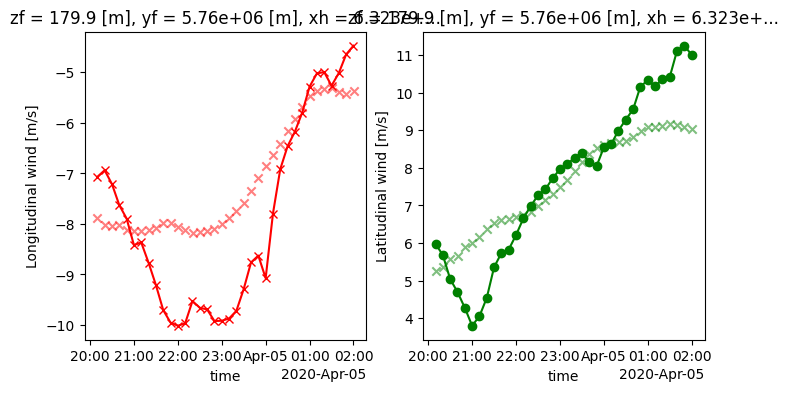

In [28]:
fig,ax = plt.subplots(ncols=2, figsize=(8,4))

if OBS_TYPE.lower() == "lidar":
    ds_obs['u'].isel(zf=5).plot(marker='x', c='red', ax=ax[0])
    ax[0].set_title('u obs')
    ds_obs['v'].isel(zf=5).plot(marker='o', c='green', ax=ax[1])
    ax[1].set_title('v obs')

# Plot the standard model realisation
ds_synth_obs['u_true'].isel(zf=5).plot.scatter(marker='x', c='red', ax=ax[0], alpha=0.5)
ds_synth_obs['v_true'].isel(zf=5).plot.scatter(marker='x', c='green', ax=ax[1], alpha=0.5)

In [30]:
output = esmda.esmda(model_prior_list=[ds_u_model_prior, ds_v_model_prior],
                     data_obs=data_obs,
                     sigma=SIGMA,
                     sim_path=sims_directory,
                     data_path=data_directory,
                     zf_model=zf_model,
                     alphas=ALPHA, 
                     data_prior=None,localization_matrix=None, callback_post=None, 
                     return_post_data=True,
                     dir_save_fields="/home/maxf/projects/da4gs/esmda/data/esmda_fields/ESMDA_ne15_a5_lidar",
                     )

ES-MDA step   1; α=2.0

Device 0: "NVIDIA GeForce RTX 3090"
  CUDA Driver Version / Runtime Version          12.0 / 12.2
  CUDA Capability Major/Minor version number:    8.6
  Total amount of constant memory:               65536 bytes
  Total amount of shared memory per block:       49152 bytes
  Total number of registers available per block: 65536
  Warp size:                                     32
  Maximum number of threads per multiprocessor:  1536
  Maximum number of threads per block:           1024
  Concurrent copy and kernel execution:          Yes with 2 copy engine(s)
  Run time limit on kernels:                     Yes
  Integrated GPU sharing Host Memory:            No
  Support host page-locked memory mapping:       Yes
  Device has ECC support:                        Disabled
  Device supports Unified Addressing (UVA):      Yes
 ---- </SimulationDependencies> ---- 

  000 has no value deps
  000 has no wait deps
 ----  <SimulationDependencies/> ---- 


/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
000: --------------- t = 65.2; speed average over 60 s 87.8393 [M/s]  cumulative: 87.8393 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           63 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  2.00000e+01  | 2.74465e-01    6     | 3.37731e-03    0     | 4.98165e-01   127     |  2.18607e+01  | 1.77656e+03  | 3.21179e+01  |
000: --------------- t = 125.2; speed average over 60 s 83.828 [M/s]  cumulative: 86.7077 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           46 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe

/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
000: --------------- t = 72.3512; speed average over 60 s 85.7567 [M/s]  cumulative: 85.7567 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           65 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  2.00000e+01  | 2.31207e-01   21     | 2.85557e-03    0     | 3.39809e-01   127     |  2.59507e+01  | 2.10116e+03  | 4.70853e+01  |
000: --------------- t = 132.351; speed average over 60 s 80.4472 [M/s]  cumulative: 84.3647 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           48 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         |

/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
000: --------------- t = 63.9047; speed average over 60 s 86.6726 [M/s]  cumulative: 86.6726 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           65 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  2.00000e+01  | 2.60976e-01    6     | 3.33404e-03    0     | 4.63681e-01   127     |  2.29906e+01  | 1.79962e+03  | 3.45065e+01  |
000: --------------- t = 123.905; speed average over 60 s 83.346 [M/s]  cumulative: 85.7393 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           47 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | 

/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
000: --------------- t = 67.2558; speed average over 60 s 87.89 [M/s]  cumulative: 87.89 [M/s] <dt> = 19.582 [s] ---------------
000: at this rate the run will finish in about           69 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  1.95820e+01  | 2.28579e-01   21     | 2.66250e-03    0     | 2.96338e-01   127     |  2.57006e+01  | 2.20643e+03  | 5.28641e+01  |
000: --------------- t = 127.256; speed average over 60 s 84.2297 [M/s]  cumulative: 86.9454 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           49 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         |

/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m01/graspOutRestart.000.nc
000: --------------- t = 65.2; speed average over 60 s 87.7057 [M/s]  cumulative: 87.7057 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           63 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  2.00000e+01  | 2.76959e-01    6     | 3.47974e-03    0     | 4.97829e-01   127     |  2.16638e+01  | 1.72427e+03  | 3.21395e+01  |
000: --------------- t = 125.2; speed average over 60 s 83.8358 [M/s]  cumulative: 86.6152 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           46 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_p

/home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspInGround.000.png: No such file or directory


reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
reading restart file: /home/maxf/projects/da4gs/esmda/runs/run_esmda/2020/04/04/00_m02/graspOutRestart.000.nc
000: --------------- t = 69.5669; speed average over 60 s 86.3879 [M/s]  cumulative: 86.3879 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           68 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | dt_pe_horz   | dt_co        |
000: |  2.00000e+01  | 2.29443e-01   21     | 2.73740e-03    0     | 3.13738e-01   127     |  2.61503e+01  | 2.19186e+03  | 5.09980e+01  |
000: --------------- t = 129.567; speed average over 60 s 83.79 [M/s]  cumulative: 85.7234 [M/s] <dt> = 20 [s] ---------------
000: at this rate the run will finish in about           49 seconds
000: |  dt           | pe           k_pe    | pe_horz      k_peh   | co            k_co    | dt_pe         | d

In [31]:
# Inflate model output
model_post = output

In [ ]:
ds_model_post_u, ds_model_post_v = utils.inflate_flattened_field(concat_membs_flat=model_post, shape_ens_3d=model_prior_shape,
                                                                da_u_example=ds_u_model_prior['member_1'], 
                                                                da_v_example=ds_v_model_prior['member_1'])


dir_post_model="/home/maxf/projects/da4gs/esmda/data/esmda_fields/ESMDA_ne15_a5_lidar"

ds_model_post_u.to_netcdf(f"{dir_post_model}/ds_u_model_post.nc")
ds_model_post_v.to_netcdf(f"{dir_post_model}/ds_v_model_post.nc")

In [20]:
def save_posterior_dict_to_netcdf(post_dict: dict, root_dir: str) -> None:
    """This function save the dictionary with posterior model/data to a directory """
    if 'model' in root_dir:
        save_name = "model_posterior"
    elif 'data' in root_dir:
        save_name = "data_posterior"
    else:
        raise ValueError("Save directory not determiable")

    print(f"SavePath: {root_dir}/{save_name}_step<NR>_member_<ID>.nc")
    for step, dict_members in post_dict.items():
        # print('here')
        for memb_idx, ds in dict_members.items():
            
            if not os.path.exists(root_dir):
                os.makedirs(root_dir)
            print(f"Save file: {root_dir}/{save_name}_{step}_{memb_idx}.nc")
            ds.to_netcdf(f"{root_dir}/{save_name}_{step}_{memb_idx}.nc")


In [56]:
# ## Save output dictionaries
# save_dicts=False
# if save_dicts:
#     save_path_dict = f"/home/maxf/projects/da4gs/esmda/data/posterior_data/{experiment_desc}/all_data"

#     dir_post_data  = f"{save_path_dict}/all_post_data"
#     save_posterior_dict_to_netcdf(post_dict=dict_data_prior, root_dir=dir_post_data)

#     """ Problem to store these files, as graspOutRestart.000.nc have been deleted (i think dict is only a pointer to those files??)"""
#     dir_post_model = f"{save_path_dict}/all_post_models"
#     # save_posterior_dict_to_netcdf(post_dict=dict_model_posterior, root_dir=dir_post_model)




In [101]:
ds_data_prior = load_data_at_step(step=0)
ds_data_posterior = load_data_at_step(step='posterior')

Loading data at step 0
Loading data posterior


In [83]:
def compute_ens_mean(ne):
    u_mean, v_mean = 0,0
    for i in range(ne):
        idx = str(i+1).zfill(2)
        ds = xr.open_dataset(f"/home/maxf/projects/da4gs/esmda/data/ensemble_data/2020/04/04/00_m{idx}/graspOutSimdata.000.nc")
        # Round time values, as otherwise the different enemble members cannot be merged, as time differs by few secs from ens to ens
        ds['time'] = ds['time'].dt.round('min')
        da_u_predobs, da_v_predobs = utils.measurement_operator(ds_u=ds['u'], ds_v=ds['v'], x_idx=64, y_idx=64, vert_levs=slice(10,300))
        u_mean += da_u_predobs
        v_mean += da_v_predobs
    u_mean /= ne
    v_mean /= ne
    return u_mean, v_mean


In [84]:
da_u_mean, da_v_mean = compute_ens_mean(ne=NE)

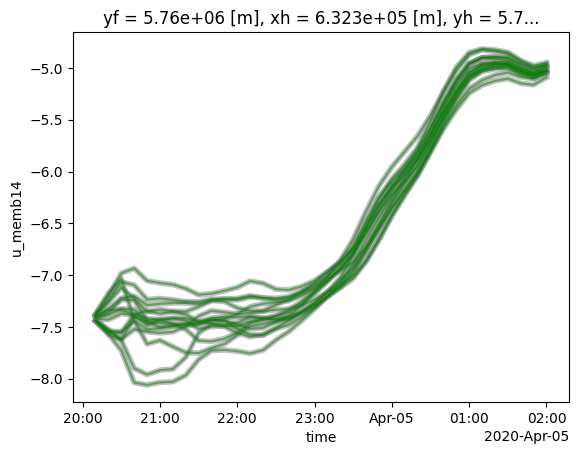

In [105]:

for var in ds_data_prior.data_vars:
    if 'u' in var:
        ds_data_prior[var].mean(dim='zf').plot(alpha=0.5, c='grey', linewidth=4)


for var in ds_data_posterior.data_vars:
    if 'u' in var:
        ds_data_posterior[var].mean(dim='zf').plot(alpha=0.5, c='green')



# da_u_mean.mean(dim='zf').plot()
# ds_obs['u_noisy'].mean(dim='zf').plot(label='true', linestyle='--', linewidth=5, alpha=0.5)
# ds_obs['u_true'].mean(dim='zf').plot(label='true', marker='o', linewidth=3, alpha=0.5)
# plt.show()
# da_v_mean.mean(dim='zf').plot()
# ds_obs['v_noisy'].mean(dim='zf').plot(label='true', linestyle='--', linewidth=5, alpha=0.5)

In [ ]:
# fig,axs =plt.subplots(ncols=2, nrows=2, figsize=(8,8))

# ax = axs.flatten()

# dict_model_posterior["Step0"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yf').plot(ax=ax[0], label='step0')
# dict_model_posterior["Step1"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yf').plot(ax=ax[0], )
# dict_model_posterior["Step2"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yf').plot(ax=ax[0], )
# dict_model_posterior["Step3"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yf').plot(ax=ax[0], )
# dict_model_posterior["Step4"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yf').plot(ax=ax[0], )
# ax[0].legend()
# dict_model_posterior["Step0"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xh').plot(ax=ax[1], label='step0')
# dict_model_posterior["Step1"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xh').plot(ax=ax[1], )
# dict_model_posterior["Step2"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xh').plot(ax=ax[1], )
# dict_model_posterior["Step3"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xh').plot(ax=ax[1], )
# dict_model_posterior["Step4"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xh').plot(ax=ax[1], )
# ax[1].legend()


# dict_model_posterior["Step0"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yh').plot(ax=ax[2], label='step0')
# dict_model_posterior["Step1"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yh').plot(ax=ax[2], )
# dict_model_posterior["Step2"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yh').plot(ax=ax[2], )
# dict_model_posterior["Step3"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yh').plot(ax=ax[2], )
# dict_model_posterior["Step4"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='yh').plot(ax=ax[2], )
# ax[2].legend()
# dict_model_posterior["Step0"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xf').plot(ax=ax[3], label='step0')
# dict_model_posterior["Step1"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xf').plot(ax=ax[3], )
# dict_model_posterior["Step2"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xf').plot(ax=ax[3], )
# dict_model_posterior["Step3"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xf').plot(ax=ax[3], )
# dict_model_posterior["Step4"]['Member10']['v'].sel(zf=slice(0,300)).mean(dim='zf').mean(dim='xf').plot(ax=ax[3], )
# ax[3].legend()

# fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
# ax=axs.flatten()
# dict_model_posterior["Step0"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[0], vmax=8, add_colorbar=False)
# dict_model_posterior["Step1"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[1], vmax=8, add_colorbar=False)
# dict_model_posterior["Step2"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[2], vmax=8, add_colorbar=True)
# dict_model_posterior["Step3"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[3], vmax=8, add_colorbar=False)
# dict_model_posterior["Step4"]['Member10']['u'].sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[4], vmax=8, add_colorbar=False)

